In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import itertools
import warnings
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import calendar

# Step 1: Visualize Tractor Sales data as time series

In [2]:
the_seals = pd.read_csv('Tractor-Sales.csv')

In [3]:
the_seals.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [4]:
the_seals.shape

(144, 2)

In [5]:

the_seals.isnull().sum()

Month-Year                0
Number of Tractor Sold    0
dtype: int64

In [6]:
# since the complete date was not mentioned, we assume that it was the first of every month
the_data = pd.date_range(start='2003-01-01',freq='MS',periods=len(the_seals))

In [7]:
the_seals['Month'] = the_data.month
the_seals['Month'] = the_seals['Month'].apply(lambda X : calendar.month_abbr[X])
the_seals['Year'] = the_data.year

In [8]:
the_seals.drop(['Month-Year'] ,axis=1, inplace=True)
the_seals.rename(columns={'Number of Tractor Sold':'Tractor Sales'},inplace=True)
the_seals = the_seals[['Month','Year','Tractor Sales']]

In [9]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
the_seals.set_index(the_data, inplace=True)

In [10]:
the_seals.head()

,Month,Year,Tractor Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [11]:
# extract out the time-series
sales_ts = the_seals['Tractor Sales']

C:\Users\Anil\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


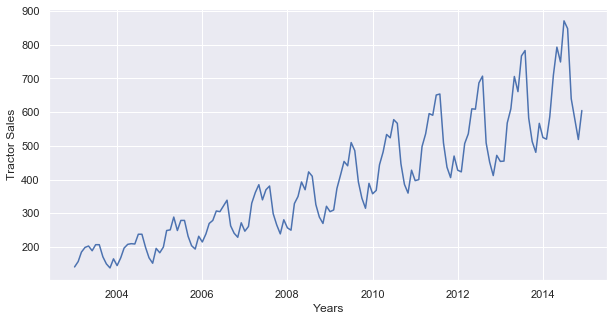

In [12]:
plt.figure(figsize=(10,5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')
plt.show()

# Step 1.1: Trend - Time Series Decomposition

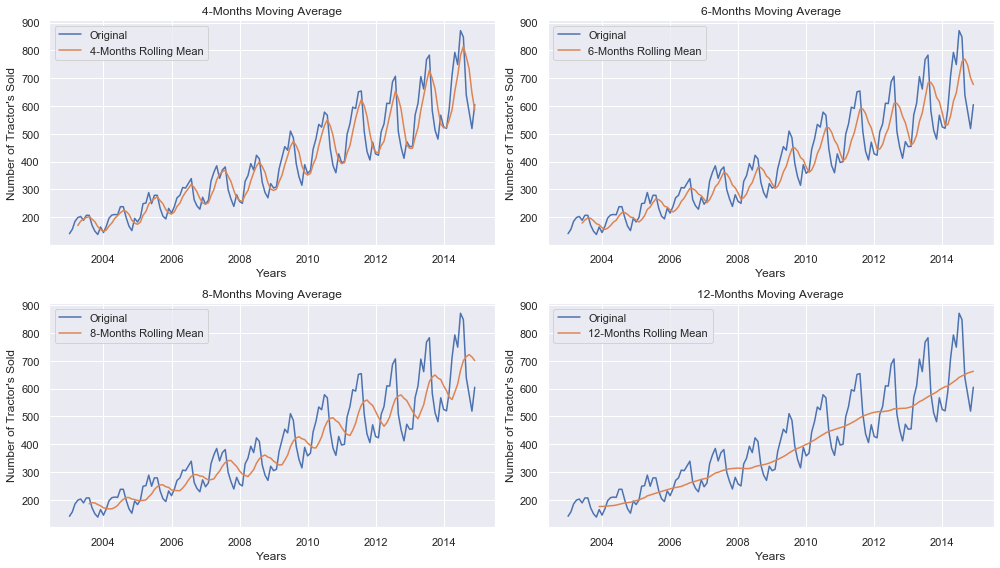

In [13]:
# We will take moving average of different time periods i.e. 4,6,8, and 12 months as shown below
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

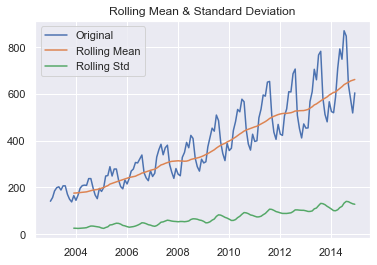

In [14]:
#Let's plot the rolling mean and standard deviation on window of 12 months

#Determing rolling statistics
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [15]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


# Step 1.2: Seasonality – Time Series Decomposition

In [16]:
#The first thing to do is to see how number of tractors sold vary on a month on month basis. We will plot a stacked annual plot to observe seasonality in our data

monthly_sales_data = pd.pivot_table(the_seals, values = "Tractor Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


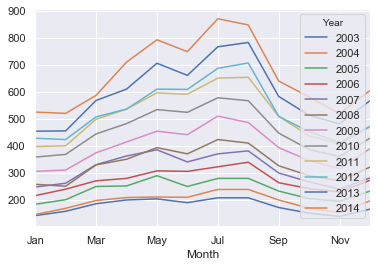

In [17]:
monthly_sales_data.plot()
plt.show()

In [18]:
yearly_sales_data = pd.pivot_table(the_seals, values = "Tractor Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


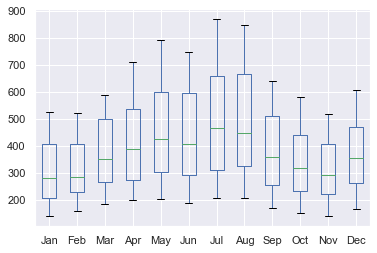

In [19]:
yearly_sales_data.boxplot()
plt.show()

Important Inferences

*The tractor sales have been increasing without fail every year.

*July and August are the peak months for tractor sales and the variance and the mean value in July and August are also much higher than any of the other months.

*We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the beginning of the year and drops down towards the end of the year. We can see a seasonal effect with a cycle of 12 months.


# Step 1.3: Irregular Remainder – Time Series Decomposition

In [20]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')


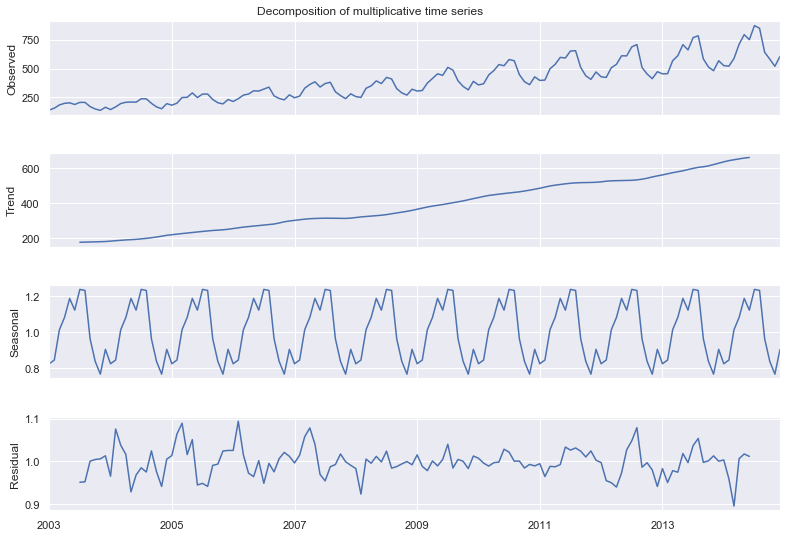

In [21]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

# ARIMA Modeling

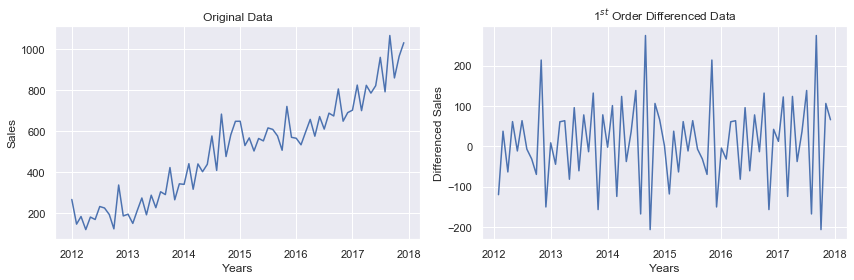

In [22]:
from io import StringIO
import requests

# convert to a dataframe for easy plot and differenciation

url = 'http://ucanalytics.com/blogs/wp-content/uploads/2017/08/dummy-sales.csv'
s = requests.get(url).text

random_df = pd.read_csv(StringIO(s))

random_df.set_index(pd.date_range(start='2012-01-01', freq='MS', periods=len(random_df)), inplace=True)

fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
axes[0].plot(random_df.index, random_df['Sales'])
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Sales")
axes[0].set_title("Original Data")
axes[1].plot(random_df.index, random_df['Sales'].diff(periods=1))
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Differenced Sales")
axes[1].set_title("1$^{st}$ Order Differenced Data")
plt.tight_layout()
plt.show()

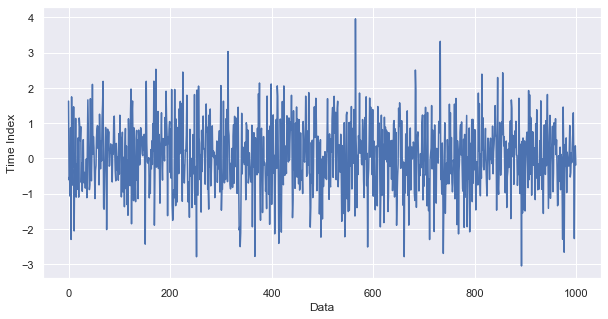

In [23]:
# generate white noise
np.random.seed(1)
# plot of discrete white noise
plt.figure(figsize=(10, 5))
white_noise = np.random.normal(size=1000)
plt.plot(white_noise)
plt.xlabel('Data')
plt.ylabel('Time Index')
plt.show()

<Figure size 432x288 with 0 Axes>

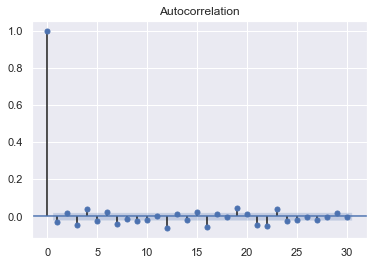

In [24]:
#ACF
plt.figure()
smt.graphics.plot_acf(white_noise, lags=30, alpha=0.5)
plt.show()

# Step 2: Difference data to make data stationary on mean (remove trend)

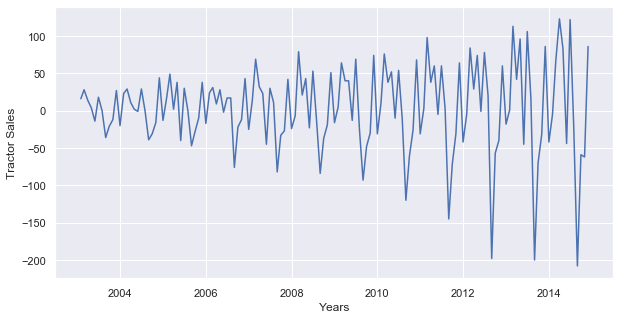

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Tractor Sales')
plt.show()

# Step 3: log transform data to make data stationary on variance

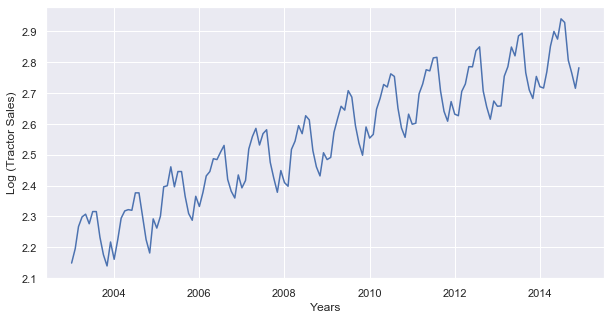

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Tractor Sales)')
plt.show()

# Step 4: Difference log transform data to make data stationary on both mean and variance

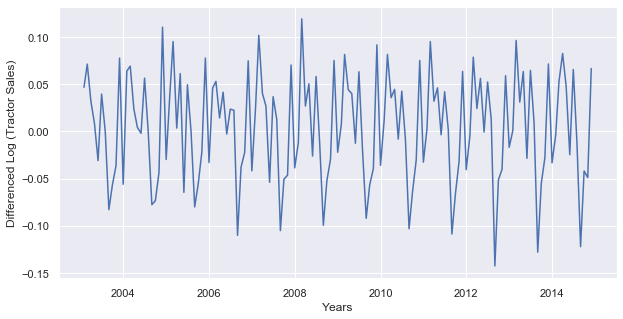

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')
plt.show()

# Step 5: Plot ACF and PACF to identify potential AR and MA model

In [28]:
sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
sales_ts_log_diff.dropna(inplace=True)

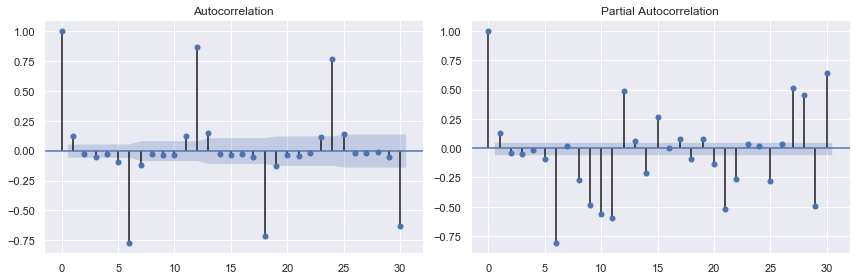

In [29]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

# Step 6: Identification of best fit ARIMA model

In [30]:

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [31]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-733.7733507577382


In [32]:
# comparing our model with the best model reported in the blog
blog_param_order = (0, 1, 1)
blog_param_seasonal_order = (0, 1, 1, 12)
blog_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=blog_param_order,
                                      seasonal_order=blog_param_seasonal_order,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
blog_results = blog_model.fit()
print("Blog SARIMAX{}x{}12 model - AIC:{}".format(blog_param_order, blog_param_seasonal_order, blog_results.aic))

Blog SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 model - AIC:-702.7857899529048


# Step 7: Predict sales on in-sample date using the best fit ARIMA model

In [33]:

best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [34]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor Sales   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 370.887
Date:                            Sat, 02 May 2020   AIC                           -733.773
Time:                                    13:40:41   BIC                           -721.922
Sample:                                01-01-2003   HQIC                          -728.958
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3572      0.069     -5.198      0.000      -0.492      -0.223
ar.S.L12       0.9932      0.006   

In [35]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [36]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
sales_ts_truth = sales_ts_log['2012-01-01':]

# Compute the mean square error
mse = ((sales_ts_forecasted - sales_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.0011


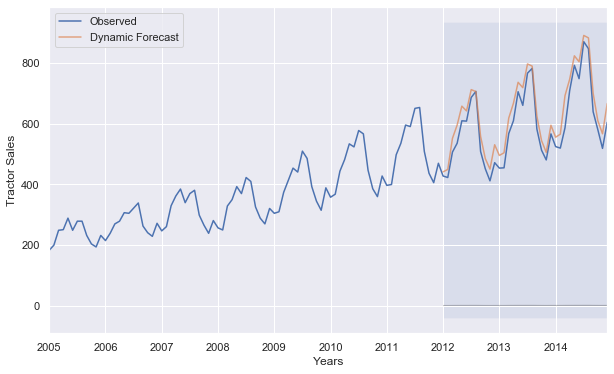

In [37]:
axis = sales_ts['2005':].plot(label='Observed', figsize=(10, 6))
np.power(10, pred_dynamic.predicted_mean).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2012-01-01'), sales_ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()

# Step 8: Forecast sales using the best fit ARIMA model

In [38]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [39]:
n_steps = 36
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,567.467103,528.223391,609.626378,528.223391,609.626378
2015-01-01,566.184124,519.947467,616.532406,519.947467,616.532406
2015-02-01,668.709844,606.983860,736.712926,606.983860,736.712926
2015-03-01,755.173223,678.376310,840.664080,678.376310,840.664080
2015-04-01,850.178726,756.518609,955.434351,756.518609,955.434351


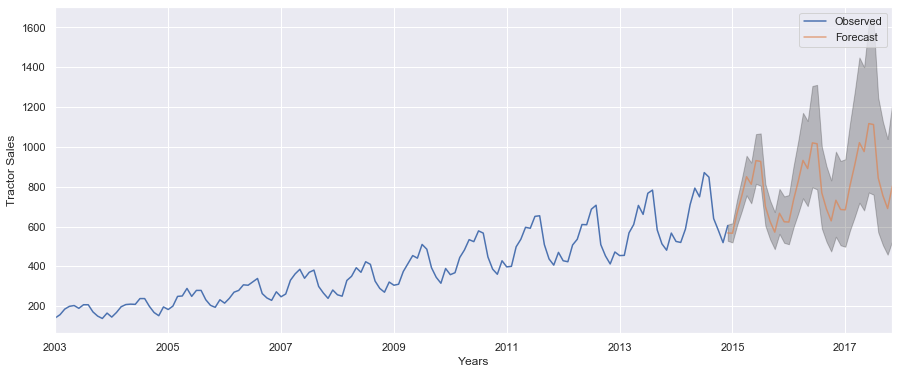

In [40]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

# Step 9: Plot ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction

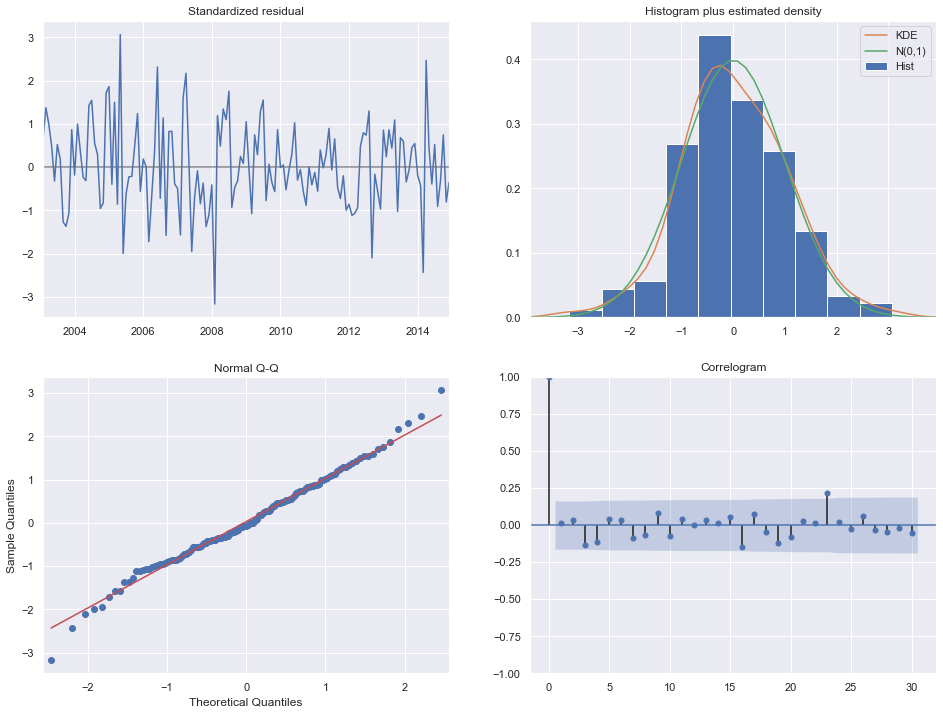

In [41]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

# Step 10: Regression with ARIMA Errors (Work in Progress)

In [42]:
url = 'http://ucanalytics.com/blogs/wp-content/uploads/2017/08/sales-and-marketing.csv'
s = requests.get(url).text

mkt_sales_data = pd.read_csv(StringIO(s))

# since the complete date was not mentioned, we assume that it was the first of every month
mkt_sales_data.set_index(pd.date_range(start='2011-01-01', freq='MS', periods=len(mkt_sales_data)), inplace=True)
mkt_sales_data.drop(['Time Period'], axis=1, inplace=True)
mkt_sales_data.rename(columns={'Sales':'Tractor-Sales'}, inplace=True)
mkt_sales_data.head(5)

,Tractor-Sales,Marketing Expense
2011-01-01,397,486.64
2011-02-01,400,501.80
2011-03-01,498,437.09
2011-04-01,536,565.16
2011-05-01,596,744.15


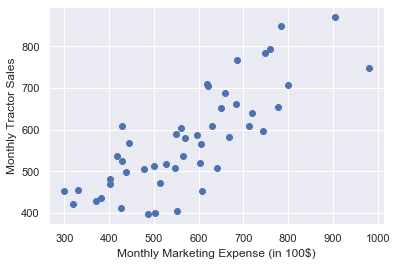

In [44]:
plt.figure()
plt.scatter(x=mkt_sales_data['Marketing Expense'], y=mkt_sales_data['Tractor-Sales'])
plt.xlabel('Monthly Marketing Expense (in 100$)')
plt.ylabel('Monthly Tractor Sales')
plt.show()

In [45]:
print("Correlation for Marketing Data: {}".format(round(mkt_sales_data.corr()['Marketing Expense']['Tractor-Sales'], 2)))

Correlation for Marketing Data: 0.8


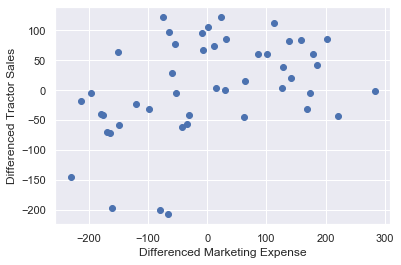

In [47]:

mkt_sales_data_diff = mkt_sales_data.diff(periods=1)
mkt_sales_data_diff.dropna(inplace=True)

plt.figure()
plt.scatter(x=mkt_sales_data_diff['Marketing Expense'], y=mkt_sales_data_diff['Tractor-Sales'])
plt.xlabel('Differenced Marketing Expense')
plt.ylabel('Differenced Tractor Sales')
plt.show()

In [48]:
print("Correlation for Stationary Data: {}".format(round(mkt_sales_data_diff.corr()['Marketing Expense']['Tractor-Sales'], 2)))

Correlation for Stationary Data: 0.41


In [49]:
len(mkt_sales_data_diff)

47

In [50]:

prev_months_corr_data = pd.DataFrame(np.column_stack((\
                                        mkt_sales_data_diff['Marketing Expense'][0:46].values,\
                                        mkt_sales_data_diff['Tractor-Sales'][1:47].values)), \
                                     columns=["Previous Month's Differenced Marketing Expense" , 
                                              "Differenced Tractor Sales"])

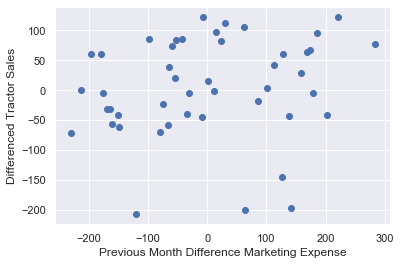

In [51]:
plt.figure()
plt.scatter(x=prev_months_corr_data["Previous Month's Differenced Marketing Expense"], \
            y=prev_months_corr_data["Differenced Tractor Sales"])
plt.xlabel("Previous Month Difference Marketing Expense")
plt.ylabel("Differenced Tractor Sales")
plt.show()

In [52]:
print(
    "Correlation of current Months's Differenced Tractor Sales with Previous Month's Differenced Marketing Expense: {}"\
    .format(round(prev_months_corr_data.corr().iloc[0,1], 2)))

Correlation of current Months's Differenced Tractor Sales with Previous Month's Differenced Marketing Expense: 0.17


In [53]:
clip_length = len(mkt_sales_data_diff)
clip_length

47

In [54]:
lagged_mkt_exp_diff_sales_data = pd.DataFrame(np.column_stack((\
                                        mkt_sales_data_diff['Marketing Expense'],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=1)[0:clip_length],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=2)[0:clip_length],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=3)[0:clip_length],\
                                        mkt_sales_data_diff['Tractor-Sales'][0:47].values)), \
                                     columns=["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2", "Diff_Mkt_Exp_Lag_3", "Diff_Sales"])

In [55]:
lagged_mkt_exp_diff_sales_data.set_index(mkt_sales_data_diff.index, inplace=True)
lagged_mkt_exp_diff_sales_data.head(10)

,Diff_Mkt_Exp,Diff_Mkt_Exp_Lag_1,Diff_Mkt_Exp_Lag_2,Diff_Mkt_Exp_Lag_3,Diff_Sales
2011-02-01,15.16,NaN,NaN,NaN,3.0
2011-03-01,-64.71,15.16,NaN,NaN,98.0
2011-04-01,128.07,-64.71,15.16,NaN,38.0
2011-05-01,178.99,128.07,-64.71,15.16,60.0
2011-06-01,-195.41,178.99,128.07,-64.71,-5.0
2011-07-01,101.47,-195.41,178.99,128.07,60.0
2011-08-01,127.30,101.47,-195.41,178.99,3.0
2011-09-01,-230.40,127.30,101.47,-195.41,-145.0
2011-10-01,-164.30,-230.40,127.30,101.47,-72.0
2011-11-01,168.75,-164.30,-230.40,127.30,-31.0


In [56]:

import sys

def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 1), q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=True,
                                                 enforce_invertibility=True)
                temp_results = temp_model.fit()

                # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
                
                

    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [57]:
#ARIMA Model No Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data["Diff_Mkt_Exp"][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:443.254447838077
                                 Statespace Model Results                                 
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -217.627
Date:                            Sat, 02 May 2020   AIC                            443.254
Time:                                    14:03:49   BIC                            450.391
Sample:                                05-01-2011   HQIC                           445.901
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Diff_Mkt_Exp     0.0233      0.039      0.5

In [58]:
#ARIMA Model with 1 month Lag Marekting Sales Data Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:445.14005342796634
                                 Statespace Model Results                                 
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -217.570
Date:                            Sat, 02 May 2020   AIC                            445.140
Time:                                    14:04:39   BIC                            454.061
Sample:                                05-01-2011   HQIC                           448.448
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp           0.0259

In [59]:
#ARIMA Model with 2 months Lag Marekting Sales Data Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:447.0778377604522
                                 Statespace Model Results                                 
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -217.539
Date:                            Sat, 02 May 2020   AIC                            447.078
Time:                                    14:05:33   BIC                            457.783
Sample:                                05-01-2011   HQIC                           451.048
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp           0.0237 

In [60]:
#ARIMA Model with 3 months Lag Marekting Sales Data Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2", "Diff_Mkt_Exp_Lag_3"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(1, 0, 0)x(1, 0, 0, 12)12 model - AIC:447.4032016009485
                                 Statespace Model Results                                 
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -216.702
Date:                            Sat, 02 May 2020   AIC                            447.403
Time:                                    14:06:28   BIC                            459.893
Sample:                                05-01-2011   HQIC                           452.035
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp           0.0111 